# Analyze results of simulated transition

In [1]:
"""Further command line arguments:
        c       script will close all open plots
        sli     data of the original simulation written in sli will be analyzed. 
                Note that at this point, the data must be of the same simulation type, 
                as specifications are loaded from .npy-files of the pynest simulation. 

    Overview over all populations: Raster plot, mean rates, mean CV of ISI per population.
"""
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys, os
import time
sys.path.append(os.path.abspath('../')) # include path with style
sys.path.append(os.path.abspath('../trans_simulation/')) # include path with simulation specifications
import style; reload(style)
# Close other plots by adding 'c' after 'run <script>' 
if 'c' in sys.argv:
    plt.close('all')
picture_format = '.pdf'
figure_path = "./figures"
######################################################
# Import specific moduls
import network_params_trans; reload(network_params_trans)
import user_params_trans as user; reload(user)
%matplotlib inline

xfactor = 2
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
plotting = True

def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)

def print_perc(i, i_total):
    i_perc = round(100 * i / i_total)
    print("%i"%(i_perc), end="\r")
    

In [2]:
# DATA
data_path = user.data_dir
sim_spec = "a1.0_t5.2_00"
# Original data
file_name  = sim_spec + ".hdf5"  
# Computed results
res_file_name = sim_spec + "_res.hdf5"

In [4]:
# Open file: data
data_file = h5py.File(os.path.join(data_path, file_name), "r")


area    = data_file.attrs["area"]   
t_sim   = data_file.attrs["t_sim"]  
t_trans = data_file.attrs["t_trans"]
dt      = data_file.attrs["dt"]    
populations   = data_file.attrs["populations"].astype("|U4")
layers        = data_file.attrs["layers"].astype("|U4")        
types         = data_file.attrs["types"].astype("|U4")     
n_populations = data_file.attrs["n_populations"]
n_layers      = data_file.attrs["n_layers"]       
n_types       = data_file.attrs["n_types"] 

t_measure = t_sim - t_trans

# labels & colors: need to be adapted if n_types != (e, i)
layer_colors = style.colors[:n_layers]
colors = np.array([color for color in layer_colors for i in range(n_types)])
colors[1::2] = colors[1::2] * 0.4   #### adapt for more than two types!
if reverse_order:
    populations = populations[::-1]
    layers = layers[::-1]
    types = types[::-1]
    colors = colors[::-1]
data_file.close()

In [4]:
# Analyze spikes
# Open file: data and results
data_file = h5py.File(os.path.join(data_path, file_name), "r")
res_file = h5py.File(os.path.join(data_path, res_file_name), "w")
# Raster plot
t_min_raster = 0.2
t_max_raster = min(t_sim, 1)
max_plot = 0.1 # part of recorded neurons plotten in raster plot

# Spike histogram
bin_width_spikes = 3e-3  # s
n_bins_spikes = int(t_measure / bin_width_spikes) 

for sim_spec2 in data_file.keys():
    print(sim_spec2)
    t0 = time.time()
    
    # Results
    res_grp = res_file.create_group(sim_spec2)
    res_raster = res_grp.create_group("raster") 

    # Data
    grp = data_file[sim_spec2 + "/spikes"]
    dt = grp.attrs["dt"]
    n_neurons_rec_spike = grp.attrs["n_neurons_rec_spike"][:]

    if reverse_order:
        n_neurons_rec_spike = n_neurons_rec_spike[::-1]
    offsets = np.append([0], np.cumsum(n_neurons_rec_spike)) * max_plot
    
    # Mean and Std of firing rates and CV of ISI
    rates_mean  = np.zeros(n_populations)
    rates_std   = np.zeros(n_populations)
    cv_isi_mean = np.zeros(n_populations)
    cv_isi_std  = np.zeros(n_populations)
    synchrony   = np.zeros(n_populations)
    no_isi = []
    
    for i, population in enumerate(populations):
        res_raster_pop = res_raster.create_group(str(population))
        
        # Get data
        subgrp = grp[str(population)]
        raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
        indices         = subgrp["rec_neuron_i"][:]
        
        # Firing rate:
        n_spikes = np.diff(indices)
        rates = n_spikes / t_measure # Hz

        cv_isi_all = np.empty(0)    
        rates = []
        hist_spikes = np.zeros(n_bins_spikes)
        for j in range(len(indices) - 1):
            times = raw_times_all[indices[j]:indices[j+1]]
            times = times[times > t_trans]
            
            # raster, histogram, etc
            n_spikes = len(times)
            rates.append(n_spikes / t_measure)
            hist_spikes += np.histogram(times, bins=n_bins_spikes, range=(t_trans, t_sim))[0]
            if n_spikes > 1:
                isi = np.diff(times)
                mean_isi = np.mean(isi)
                var_isi = np.var(isi)
                cv_isi = var_isi / mean_isi**2
                cv_isi_all = np.append(cv_isi_all, cv_isi)
            else:
                no_isi.append(str(population) + '_' + str(j))
            
            # data for raster plot
            if j < len(indices) * max_plot:
                raster_mask = (times > t_min_raster) * (times < t_max_raster)
                n_spikes_raster = min(n_spikes, sum(raster_mask))
                neuron_ids_raster = [j]*n_spikes_raster + offsets[i]
                raster_data = np.vstack((times[raster_mask], neuron_ids_raster))
                res_raster_pop.create_dataset(str(j), data=raster_data)

        # Means
        rates_mean[i]   = np.mean(rates)
        rates_std[i]    = np.std(rates)
        cv_isi_mean[i]  = np.mean(cv_isi_all)
        cv_isi_std[i]   = np.std(cv_isi_all)
        synchrony[i]    = np.var(hist_spikes) / np.mean(hist_spikes)
        
    res_raster.attrs["t_min_raster"] = t_min_raster
    res_raster.attrs["t_max_raster"] = t_max_raster
    res_raster.attrs["ymax_raster"] = offset[-1]
    res_raster.attrs["yticks"] = (offsets[1:] - offsets[:-1]) * 0.5 + offsets[:-1]
        
    res_grp.create_dataset("rates_mean", data=rates_mean)
    res_grp.create_dataset("rates_std", data=rates_std)
    res_grp.create_dataset("cv_isi_mean", data=cv_isi_mean)
    res_grp.create_dataset("cv_isi_std", data=cv_isi_std)
    res_grp.create_dataset("synchrony", data=synchrony)
         
    t_calc = time.time() - t0
    print("Time for calculation: ", t_calc)
          
data_file.close()
res_file.close()

# Free memory from its chains
raw_times_all = None
times = None
raster_mask = None
n_spikes_raster = None
neuron_ids_raster = None
raster_data = None

d0.00_j1.00_sdJ0.00
Time for calculation:  12.440272569656372
d0.10_j1.00_sdJ0.00
Time for calculation:  3.5206551551818848
d0.20_j1.00_sdJ0.00
Time for calculation:  2.991783380508423
d0.30_j1.00_sdJ0.00
Time for calculation:  2.6124634742736816
d0.40_j1.00_sdJ0.00
Time for calculation:  2.4975125789642334
d0.50_j1.00_sdJ0.00
Time for calculation:  2.4482204914093018
d0.60_j1.00_sdJ0.00
Time for calculation:  2.4314181804656982
d0.70_j1.00_sdJ0.00
Time for calculation:  2.501514196395874
d0.80_j1.00_sdJ0.00
Time for calculation:  2.510606527328491
d0.90_j1.00_sdJ0.00
Time for calculation:  2.4184136390686035
d1.00_j1.00_sdJ0.00
Time for calculation:  2.406310558319092


/usr/lib/python3/dist-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:79: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


d0.00_j1.00_sdJ0.00


NameError: name 'yticks' is not defined

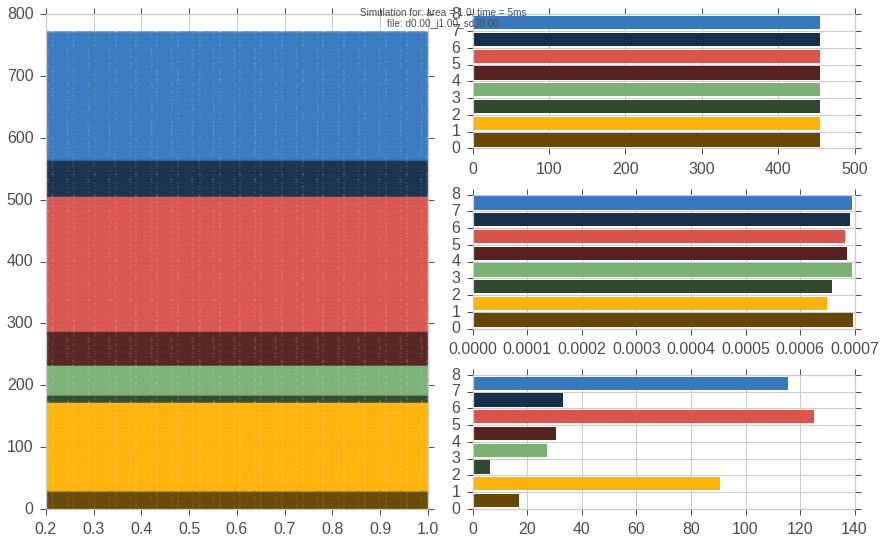

In [8]:
# Open file: results
res_file = h5py.File(os.path.join(data_path, res_file_name), "r")

# PLOTTING
for sim_spec2 in res_file.keys():  
    print(sim_spec2)
    res_grp = res_file[sim_spec2]
    res_raster = res_grp["raster"]
    
    rates_mean   = res_grp["rates_mean"]
    rates_std    = res_grp["rates_std"]
    cv_isi_mean  = res_grp["cv_isi_mean"]
    cv_isi_std   = res_grp["cv_isi_std"]
    synchrony    = res_grp["synchrony"]
    
    fig = plt.figure()
    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + sim_spec2
    
    fig.suptitle(suptitle, y=0.98)
    # Raster plot
    ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=3)
    # Rates
    ax1 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
    # CV of interspike interval (ISI)
    ax2 = plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
    # Synchrony
    ax3 = plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)    
    
    y_mean = np.arange(n_populations) + 0.1
    bar_height = 0.8 
    for i, population in enumerate(populations):


        res_raster_pop = res_raster[str(population)]
        for times, neuron_ids in res_raster_pop.values():
            ax0.plot(times, neuron_ids, '.', ms=3, color=colors[i], label=population)
        ax1.barh(y_mean[i], rates_mean[i], height=bar_height, color=colors[i], linewidth=0)
        ax2.barh(y_mean[i], cv_isi_mean[i], height=bar_height, color=colors[i], linewidth=0)
        ax3.barh(y_mean[i], synchrony[i],   height=bar_height, color=colors[i], linewidth=0)    
      

    # Raster Plot
    t_min_raster = res_raster.attrs["t_min_raster"]
    t_max_raster = res_raster.attrs["t_max_raster"]
    ymax_raster = res_raster.attrs["ymax_raster"]
    yticks = res_raster.attrs["yticks"]
    
    xlim = (t_min_raster, t_max_raster)
    ylim = (0, ymax_raster)
    ax0.set_yticks(yticks)
    ax0.set_yticklabels(populations)
    ax0.set_xlabel('simulation time / s')
    ax0.set_ylabel('Layer')
    ax0.set_xlim(*xlim)
    ax0.set_ylim(*ylim)
    ax0.grid(False)
      
    # Rates
    ax1.set_xlabel('firing rate / Hz')
    # CV of ISI
    ax2.set_xlabel('CV of interspike intervals / Hz')
    # Synchrony
    ax3.set_xlabel('Synchrony')
    
    ylim_mean = (0, n_populations)
    yticks_mean = np.arange(n_types * 0.5, n_populations, n_types)
    for ax in (ax1, ax2, ax3):
        #ax.set_ylabel('Layer')
        ax.set_yticks(yticks_mean)
        ax.set_yticklabels(layers)
        ax.set_ylim(*ylim_mean)
        ax.grid(False)
    
    # Legend; order is reversed, such that labels appear correctly
    for i in range(n_types):
        ax1.barh(0, 0, 0, color=colors[-(i+1)], label=types[-(i+1)], linewidth=0)
    ax1.legend(loc='best')
    
    for ax in fig.axes:
        style.fixticks(ax)
    fig_name = "cell_activity_" + sim_spec + "_" + sim_spec2
    
    fig.savefig(os.path.join(figure_path,fig_name + picture_format))
    
res_file.close()

# Theoretical predictions

In [8]:
"""mean_field_trans.py

Imports mf_trans and mf_plot.

Numerical analysis of the equations corresponding to the 
stationary solutions of the mean field approximation of the 
cortical microcircuit model. 

8 coupled integral equations are solved numerically. 
"""
from scipy.optimize import root
sys.path.append(os.path.abspath('../mean_field/')) # include path with mean field approximation
import mf_trans as model; reload(model)
import mf_micro as mf_micro; reload(mf_micro)
import mf_plot; reload(mf_plot)


# Global parameters
choose_model = "brunelA"  # brunelA, brunelB for corresponding models!
n_layer = 4
n_types = 2
n_pop = n_layer * n_types
print("Model: ", choose_model)
print("n layers: ", n_layer)
# Create reference instance containing parameters and functions:
# (used mostly for plotting)
mf_net0  = model.mf_net()
plot_pops= mf_net0.populations    # These populations are plotted
if not type(plot_pops) == np.ndarray:
    plot_pops = np.array([plot_pops])

Model:  brunelA
n layers:  4


In [9]:
######################################################
# Functions
######################################################
def cool_C_ab(v_guess_0, step_init = 0.01, d_step=0.5, tolerance=5, jacobian=False, root_method='hybr', options=None, vary_j02=False):
    """Iteratively change C_ab from C_B = Brunel's to C_M = microcircuit 
    on the straight line connecting C_B and C_M.
    If not disabled, j02 varied as well.
    Returns distances, v0s[distance, population], failures
    """
    print("Iterate over C_ab")
    # initiate
    g   = 4.
    j02_init = 1.
    j02 =   j02_init
    v_guess = v_guess_0
    C_B     = model.mf_net().C_ab
    distances   = []
    failures    = np.array([])
    mf_net = model.mf_net(g=g, j02=j02, C_ab=C_B)
    if jacobian:
        jac = mf_net.jacobian
    else:
        jac = False
    sol = root(mf_net.root_v0, v_guess, jac=jac, method=root_method, options=options)
    if sol["success"]:
        v0  = sol["x"]
        if np.all(v0 < 1./mf_net.t_ref): 
            v0s     = v0
            distances.append(0.)
            v_guess = v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")
    # Define steps and matrices
    step    = step_init     # initial step size
    C_M     = mf_micro.mf_net().C_ab
    delta_C = C_M - C_B
    #delta_C[deltaC > 0] = 0     # only increasing
    #delta_C[:, 0::2] = 0        # only excitatory
    delta_j02    = 1.
    distance    = 0.
    n_fails = 0
    n_succ  = 0
    # Go on
    print("\t")
    while distance <= 1.:
        distance += step
        C_ab    = C_B + distance * delta_C
        if vary_j02:
            j02     = j02_init + distance * delta_j02
        mf_net  = model.mf_net(g=g, j02=j02, C_ab=C_ab)
        try:
            sol = root(mf_net.root_v0, v_guess, jac=jac, method=root_method, options=options)
            if sol["success"]:
                v0  = sol["x"]
                if np.all(v0 < 1./mf_net.t_ref): 
                    v0s = np.vstack((v0s, v0))
                    distances.append(distance)
                    v_guess = v0
                    n_fails = 0
                    n_succ  +=1
                    if n_succ >= tolerance and step < step_init:
                        print("succ\t%.5f\t%i %i"%(distance, n_succ, np.log(step)/np.log(d_step)))
                        step /= d_step
                else:       # converged unphysically (v0 >= 1/t_ref)
                    raise Exception("unphysical")
            else:   
                raise Exception("no solution")
        except: # no (good) solution found
            failures = np.append(failures, distance)
            if n_fails == 0:
                distances.pop()
                v0s = np.delete(v0s, -1, axis=0)
            n_fails += 1
            n_succ   = 0
            print("fail\t%.5f\t%i %i"%(distance, n_fails, np.log(step)/np.log(d_step)))
            distance = distances[-1]
            step    *= d_step
            if n_fails >= tolerance:
                print("Tolerance exceeded at distance = %.3f"%distance)
                break
    distances = np.array(distances)
    return(distances, v0s, failures, C_ab, C_M, step)     


def diagnostics(log):
    """Currently not working"""
    successes       = np.sum(log ==  1) # converged successful     
    nots            = np.sum(log ==  0) # after break
    failures        = np.sum(log == -1) # algorithm stopped unsuccessfull
    exceptions      = np.sum(log == -2) # algorithm yielded NaN/overflow
    unphysicals     = np.sum(log == -3) # converged unphysically (v0 > 1/t_ref)
    print("%i\t%i\t%i\t%i\t%i"%(successes, nots, failures, exceptions, unphysicals))

In [10]:
######################################################
# Solving
######################################################
jacobian        = False     # whether to use calculated jacobian
root_method     = ['hybr', 'lm', 'broyden1', 'anderson', 'krylov'][0]
print("Method: ", root_method)
options         = None
vary_j02 = False

plotting = True
iterate_g = False              # iterate g for fixed v_ext
iterate_j02 = False             # iterate j02 for g=4
iterate_C = False

iterate_C = True
if iterate_C:
    v_guess0    = np.array([131, 127, 147, 141, 144, 141, 172, 147])
    d_step      = 0.1   # ratio by which step is reduced
    step_init   = d_step**3  # initial step size
    tolerance   = 10     # number of fails accepted at one distance
    t_int0      = time.time()
    dists, v0s, fails, C_ab, C_M, final_step  = cool_C_ab(v_guess0, step_init, d_step, tolerance, jacobian, root_method, options, vary_j02)
    t_int1      = time.time() - t_int0
    print("Integration time: %.2f"%(t_int1))

if iterate_g:
    v_guess0 = np.array([2.]*n_pop)  # initial guess
    gs        = np.arange(10., 4., -0.1)
    #v_guess0 = np.array([131, 127, 147, 141, 144, 141, 172, 147])
    #gs        = np.array([4.])

    t_int0      = time.time()
    v0s, log  = v0_g(v_guess0, gs, jacobian, root_method, options)
    t_int1      = time.time() - t_int0
    print("Integration time: %.2f"%(t_int1))
    print("succ.\tnots\tfail\texcept\tv >= 500 Hz")
    diagnostics(log)
    
# iterate J for g = 4.
if iterate_j02:
    v_guess0    = np.array([131, 127, 147, 141, 144, 141, 172, 147])
    j02s        = np.arange(1, 2.0, 0.001)

    t_int0      = time.time()
    v0s, log    = v0_j02(v_guess0, j02s, jacobian, root_method, options)
    t_int1      = time.time() - t_int0
    print("Integration time: %.2f"%(t_int1))
    print("succ.\tnots\tfail\texcept\tv >= 500 Hz")
    diagnostics(log)

/usr/lib/python3/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg)
/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Method:  hybr
Iterate over C_ab
	
fail	0.38900	1 3
fail	0.38760	1 4
fail	0.38741	2 5
fail	0.38740	3 6
fail	0.38740	4 7
fail	0.38740	5 8
fail	0.38740	6 9
fail	0.38740	7 10
fail	0.38740	8 11
fail	0.38740	9 12
fail	0.38740	10 13
Tolerance exceeded at distance = 0.387
Integration time: 43.74


/usr/lib/python3/dist-packages/scipy/integrate/quadpack.py:295: UserWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg)


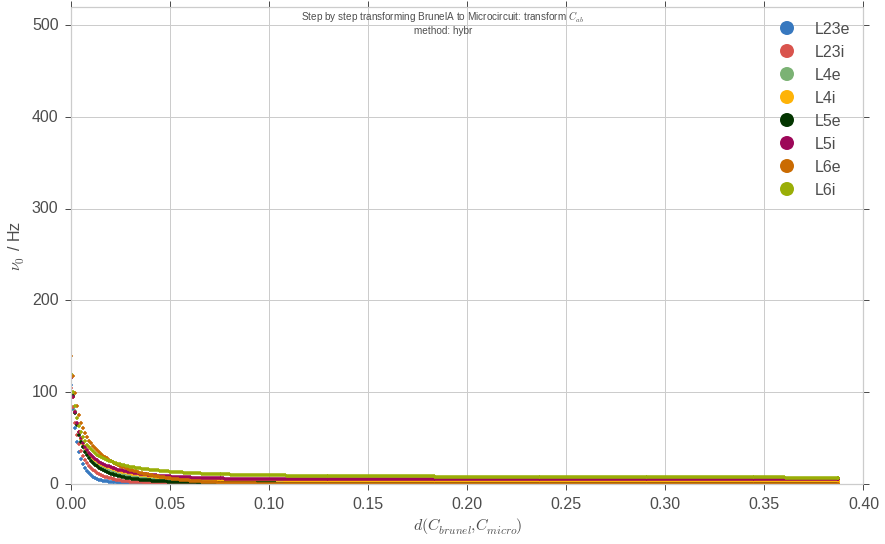

In [11]:
######################################################
# Plotting
######################################################
if plotting:
    if iterate_C:
        suptitle = "Step by step transforming BrunelA to Microcircuit: transform $C_{ab}$" + \
            "\nmethod: " + root_method
    if iterate_j02:
        suptitle = "Step by step transforming BrunelA to Microcircuit: transform $J_{L23e, L4e}$" + \
            "\nmethod: " + root_method
    plot = mf_plot.mf_plot(mf_net0, suptitle, plot_pops) 

    if iterate_C:
        plot.plot_transform(dists, v0s, xlabel="$d(C_{brunel}, C_{micro})$")
    
    if iterate_g:
        plot.plot_transform(gs, v0s, xlabel="$g$")
    
    if iterate_j02:
        plot.plot_transform(j02s, v0s, xlabel="$\\frac{J_{L23e, L4e}}{J}$")
    

    fig_name = 'mean_field_v0'
    #plot.fig.savefig(figure_path + fig_name + picture_format)